In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8
9,Sei,Sei,C9


In [8]:
dataset_renaming = {
    "complex_traits_matched_9": "Complex traits\nMatched by chromosome\n(1140 positives)",
    "complex_traits_v22_matched_9": "Complex traits\nMatched by gene\n(959 positives)",
}

subset_renaming = {
    "all": "All",
}

In [9]:
datasets = [
    "complex_traits_matched_9",
    "complex_traits_v22_matched_9",
]

subsets = [
    "all",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "CADD",
    "GPN-MSA",
    "Borzoi",
]

model_zero_shot_score = {
    "CADD": "CADD.plus.RawScore",
    "Borzoi": "Borzoi_L2_L2.plus.all",
    "GPN-MSA": "GPN-MSA_absLLR.plus.score",
}

metric = "AUPRC"

def get_model_path(model, modality, dataset, subset, metric):
    if modality == "Linear probing":
        if subset == "all":
            predictor = f"{model}.LogisticRegression.chrom"
        else:
            predictor = f"{model}.LogisticRegression.chrom.subset_from_all"
    elif modality == "Zero-shot":
        predictor = model_zero_shot_score[model]
    return f"../../results/dataset/{dataset}/{metric}_by_chrom_weighted_average/{subset}/{predictor}.csv"

In [10]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                path = get_model_path(model, modality, dataset, subset, metric)
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model_renaming.get(model, model),
                    df["score"],
                    df["se"]]
                )
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", metric, "se"])
df

,dataset,subset,modality,model,AUPRC,se
0,Complex traits\nMatched by chromosome\n(1140 p...,All,Zero-shot,CADD,0.249900,0.010183
1,Complex traits\nMatched by chromosome\n(1140 p...,All,Zero-shot,GPN-MSA,0.223643,0.009396
2,Complex traits\nMatched by chromosome\n(1140 p...,All,Zero-shot,Borzoi,0.235739,0.009155
3,Complex traits\nMatched by chromosome\n(1140 p...,All,Linear probing,CADD,0.283858,0.012406
4,Complex traits\nMatched by chromosome\n(1140 p...,All,Linear probing,GPN-MSA,0.269382,0.011520
5,Complex traits\nMatched by chromosome\n(1140 p...,All,Linear probing,Borzoi,0.296688,0.014071
6,Complex traits\nMatched by gene\n(959 positives),All,Zero-shot,CADD,0.214208,0.008466
7,Complex traits\nMatched by gene\n(959 positives),All,Zero-shot,GPN-MSA,0.200924,0.010863
8,Complex traits\nMatched by gene\n(959 positives),All,Zero-shot,Borzoi,0.234867,0.010461
9,Complex traits\nMatched by gene\n(959 positives),All,Linear probing,CADD,0.228873,0.011433


In [13]:
def plot_subset(subset):
    df_s = df.query("subset == @subset")

    g = sns.FacetGrid(
        df_s,
        col="dataset",
        row="modality",
        margin_titles=True,
        sharex="col",
        sharey=False,#"row",
        height=2.2,
        aspect=1.35,
    )

    def my_boxplot(data, **kwargs):
        data = data.sort_values(metric, ascending=False)
        ax = plt.gca()
        g = sns.barplot(
            data=data,
            y="model",
            x=metric,
            ax=ax,
            palette=palette,
            #showfliers=False, whis=0, # optional
        )
        ax.errorbar(
            x=data[metric],
            y=data["model"],
            xerr=data["se"],
            fmt='none',      # Do not add markers (those are already in the pointplot)
            color="black",
        )

    g.map_dataframe(my_boxplot)

    g.set(
        ylabel="",
        xlim=0.1 if metric == "AUPRC" else 0.5,
    )
    g.set_titles(
        col_template="{col_name}", row_template="{row_name}",
        fontweight="bold",
        size=12,
    )
    g.tight_layout()
    plt.savefig(f"../../results/plots/performance_gene_matched_complex.pdf", bbox_inches="tight")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

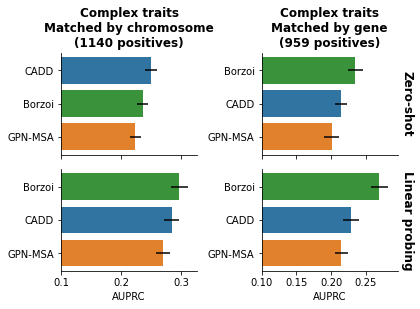

In [14]:
plot_subset("All")